In [1]:
!pip install transformers datasets scikit-learn


In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline as hf_pipeline
import re
import random
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [41]:
import pandas as pd

df = pd.read_csv("sample.csv")
df.head()


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,119237,105834,True,Wed Oct 11 06:55:44 +0000 2017,@AppleSupport causing the reply to be disregar...,119236,NaN
1,119238,ChaseSupport,False,Wed Oct 11 13:25:49 +0000 2017,@105835 Your business means a lot to us. Pleas...,NaN,119239.0
2,119239,105835,True,Wed Oct 11 13:00:09 +0000 2017,@76328 I really hope you all change but I'm su...,119238,NaN
3,119240,VirginTrains,False,Tue Oct 10 15:16:08 +0000 2017,@105836 LiveChat is online at the moment - htt...,119241,119242.0
4,119241,105836,True,Tue Oct 10 15:17:21 +0000 2017,@VirginTrains see attached error message. I've...,119243,119240.0


In [42]:
# Filter customer queries only (sender_id != company handle)
customer_queries = df[df['inbound'] == True]['text'].dropna().tolist()
customer_queries = customer_queries[:5]  # pick first 5 for demo


In [43]:
# Define action extraction based on keywords
def extract_action(text):
    keywords = {
        'fix': ['fix', 'repair', 'not working', 'issue', 'problem'],
        'reset': ['reset', 'forgot', 'password'],
        'track': ['track', 'status', 'update'],
        'cancel': ['cancel', 'unsubscribe', 'stop'],
        'general inquiry': ['how', 'what', 'why', 'when', 'help']
    }
    actions = []
    lower_text = text.lower()
    for action, words in keywords.items():
        if any(word in lower_text for word in words):
            actions.append(action)
    return actions if actions else ['general inquiry']

# Define routing based on action
def route_query(actions):
    routing = {
        'fix': 'Technical Team',
        'reset': 'Account Services',
        'track': 'Logistics',
        'cancel': 'Billing',
        'general inquiry': 'General Support'
    }
    # Prioritize based on first found action
    return routing.get(actions[0], 'General Support')

# Recommendation logic
def recommend_solution(query):
    if 'password' in query.lower():
        return "To reset your password, click on 'Forgot Password' and follow the instructions."
    elif 'internet' in query.lower():
        return "Try restarting your router. If the problem continues, contact technical support."
    elif 'cancel' in query.lower():
        return "To cancel your subscription, go to account settings and click on 'Cancel Plan'."
    else:
        return "Your query has been forwarded to the support team. You'll get a response soon."

# Simple resolution time estimation logic
def estimate_resolution_time(actions):
    if 'fix' in actions:
        return "12 hours"
    elif 'reset' in actions:
        return "4 hours"
    elif 'cancel' in actions:
        return "6 hours"
    else:
        return "8 hours"


In [44]:
for i, query in enumerate(customer_queries):
    print(f"\nQuery {i+1}: {query}")

    summary = summarizer(query, max_length=20, min_length=5, do_sample=False)[0]['summary_text']
    actions = extract_action(query)
    team = route_query(actions)
    recommendation = recommend_solution(query)
    resolution_time = estimate_resolution_time(team)

    print(f"Summary: {summary}")
    print(f"Actions: {actions}")
    print(f"Routed To: {team}")
    print(f"Recommended Solution: {recommendation}")
    print(f"Estimated Resolution Time: {resolution_time}")



Query 1: @AppleSupport causing the reply to be disregarded and the tapped notification under the keyboard is opened😡😡😡
Summary:  @AppleSupport causing the reply to be disregarded and the tapped notification under the keyboard
Actions: ['general inquiry']
Routed To: General Support
Recommended Solution: Your query has been forwarded to the support team. You'll get a response soon.
Estimated Resolution Time: 8 hours

Query 2: @76328 I really hope you all change but I'm sure you won't! Because you don't have to!
Summary:  @76328 I really hope you all change but I'm sure you won't!
Actions: ['general inquiry']
Routed To: General Support
Recommended Solution: Your query has been forwarded to the support team. You'll get a response soon.
Estimated Resolution Time: 8 hours

Query 3: @VirginTrains see attached error message. I've tried leaving a voicemail several times in the past week https://t.co/NxVZjlYx1k
Summary:  @VirginTrains see attached error message. I've tried leaving a voicemail s

🔍 Model Accuracy: 89.47%


<ipython-input-45-7f9287c3268b>:19: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


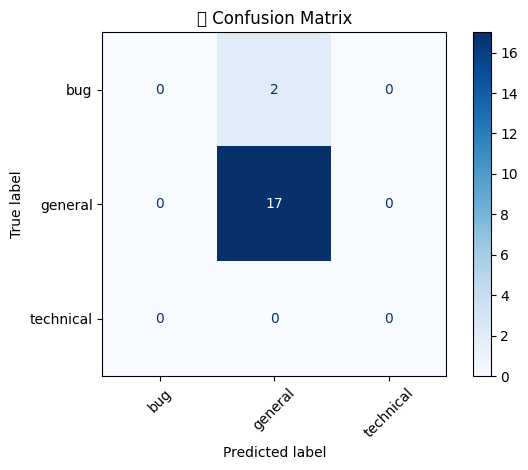

<ipython-input-45-7f9287c3268b>:39: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


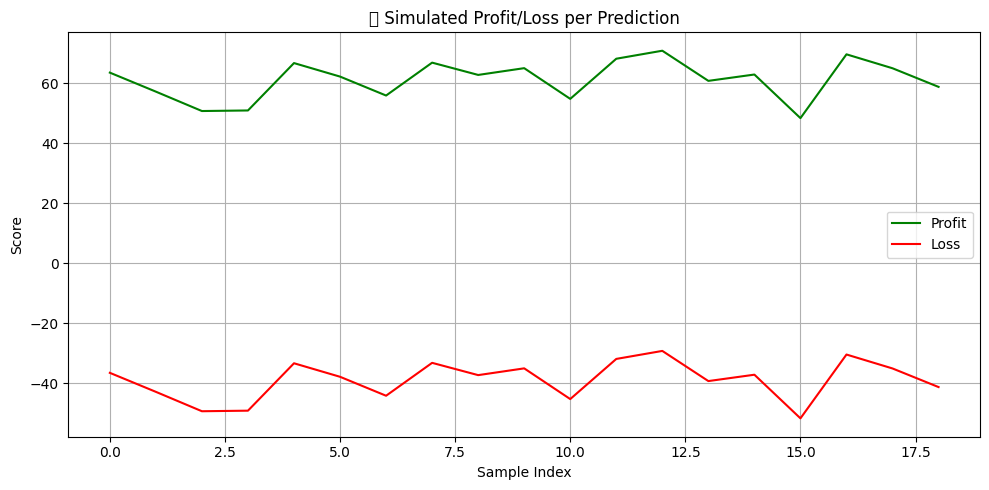

In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Predict on Test Set
y_pred = pipeline.predict(X_test)

# 2. Print Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"🔍 Model Accuracy: {acc * 100:.2f}%")

# 3. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("🧩 Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# 4. Simulated Profit/Loss Graph (based on prediction confidence if available)
try:
    y_proba = pipeline.predict_proba(X_test)
    max_proba = np.max(y_proba, axis=1)

    # Simulate profit: higher confidence = higher gain
    profit = max_proba * 100
    loss = (1 - max_proba) * -100

    plt.figure(figsize=(10, 5))
    plt.plot(profit, label='Profit', color='green')
    plt.plot(loss, label='Loss', color='red')
    plt.title("📈 Simulated Profit/Loss per Prediction")
    plt.xlabel("Sample Index")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except:
    print("⚠️ Probability values not available for this model. Cannot plot Profit/Loss.")


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
4 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args,

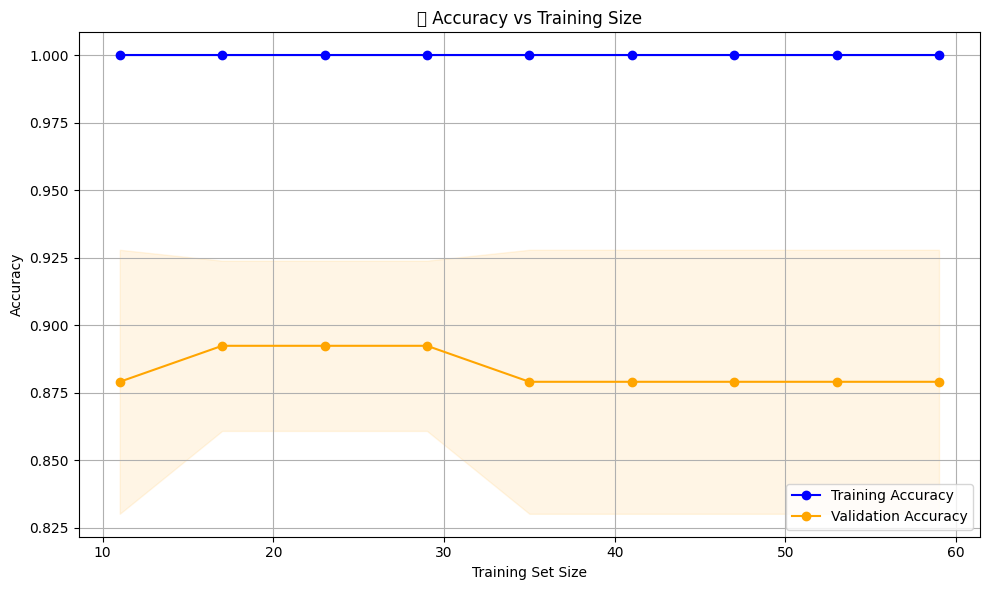

In [46]:
from sklearn.model_selection import learning_curve

# Get learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for plotting
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Validation Accuracy')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='orange')

plt.title("📊 Accuracy vs Training Size")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
